In [ ]:
# We need some additional libraries to run this notebook

!pip install git+https://github.com/berni-lehner/hyperpyper.git
!pip install gdown

  Cloning https://github.com/berni-lehner/hyperpyper.git to /tmp/pip-req-build-4o68abhn
  Running command git clone --filter=blob:none --quiet https://github.com/berni-lehner/hyperpyper.git /tmp/pip-req-build-4o68abhn
  Resolved https://github.com/berni-lehner/hyperpyper.git to commit 61a57fd24f0cdcfca29ba912a0e9b2544a208052
  Preparing metadata (setup.py) ... done


In [ ]:
import os
from pathlib import Path
from typing import List, Union

import numpy as np
import torch
from torch import nn
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import wasserstein_distance

import matplotlib.pyplot as plt

from dotenv import load_dotenv

from hyperpyper.utils import DatasetRandSamplePlotter, HistogramPlotter
from hyperpyper.utils import GDriveDownloader

import hopfield_boosting
from hopfield_boosting import download_data
from hopfield_boosting.energy import OneSidedEnergy
from hopfield_boosting.utils.plot_util import plot_histograms, create_subplots, ax2ax
from hopfield_boosting.utils.model_util import model_file, load_model, create_model, load_model_weights
from hopfield_boosting.utils.eval_util import eval_metrics_str, dump_eval_metrics
from hopfield_boosting.utils.config_util import ConstOmegaConfLoader
from hopfield_boosting.util import infer_loader
from hopfield_boosting.ood.metrics import FPR95OODMetric

# Energy-based Hopfield Boosting for Out-of-Distribution Detection - Demo Notebook

This demo is made for reproducing the results of Hopfield boosting on SVHN using a pre-trained model and to give an initial setup for further experiments. The pre-trained model is available for download [here](https://drive.google.com/file/d/1LK1VyjvQfA3qUG8LGue0IBOy0Sja2GJb/view?usp=sharing).

## Environment Setup

First, we set up the environment and all paths to the data sets. To specify the paths to the data sets, set them in the .env-file in the root of the repository.

In [ ]:
load_dotenv()  # does not override variables from the environment

BASE_MODEL_PATH = Path(os.getenv('BASE_MODEL_PATH'))
CIFAR_ROOT = Path(os.getenv('CIFAR10_ROOT'))
IMAGENET_ROOT = Path(os.getenv('IMAGENET_ROOT'))
SVHN_ROOT = Path(os.getenv('SVHN_ROOT'))
PLACES_ROOT = Path(os.getenv('PLACES_ROOT'))
ICARTOONFACE_ROOT = Path(os.getenv('ICARTOONFACE_ROOT'))
RPC_ROOT = Path(os.getenv('RPC_ROOT'))
SHAPES3D_ROOT = Path(os.getenv('SHAPES3D_ROOT'))
FOUR_SHAPES_ROOT = Path(os.getenv('FOUR_SHAPES_ROOT'))
AFHQV2_ROOT = Path(os.getenv('AFHQV2_ROOT'))
MOEIMOUTO_FACES_ROOT = Path(os.getenv('MOEIMOUTO_FACES_ROOT'))
IMAGENETO_ROOT = Path(os.getenv('IMAGENETO_ROOT'))

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


## Instantiate model

In [ ]:
# Download pre-trained model from Google Drive
url = 'https://drive.google.com/file/d/1LK1VyjvQfA3qUG8LGue0IBOy0Sja2GJb/view?usp=sharing'
GDriveDownloader.download_and_unpack(url, BASE_MODEL_PATH)

File 'pre-trained.zip' already exists. Skipping download.


In [ ]:
# create model. We do NOT load the model weights yet. This is for illustration purposes
model_id = Path('pre-trained')
model_path = BASE_MODEL_PATH / model_id

config, resnet, projection_head, classifier = create_model(model_path, device=DEVICE)

**All model components are randomly initialized at this point**

In [ ]:
resnet # Resnet18_32x32 from OpenOOD with CIFAR-normalization built-in

CNNOODWrapper(
  (module): ResNet18_32x32(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [ ]:
projection_head # 2-layer MLP that connects the Resnet output (512d) with the Hopfield Head (128d)

MLP(
  (in_layer): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (out_layer): Linear(in_features=256, out_features=128, bias=True)
  (hidden): Sequential()
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [ ]:
classifier # linear layer that maps the Resnet-18 output (512d) to the 10 CIFAR-10 classes

Linear(in_features=512, out_features=10, bias=True)

## Dataset setup

First, let's download the required OOD data sets. Make sure that you have correctly set the paths in the `.env` file.

In [ ]:
def set_working_directory():
    hopfield_boosting_path = Path(hopfield_boosting.__file__)
    hopfield_boosting_repo = hopfield_boosting_path.parents[1]
    os.chdir(hopfield_boosting_repo)

def are_datasets_available():
    return Path(SVHN_ROOT).exists() and Path(PLACES_ROOT).exists()

def download_datasets_if_not_present():
    if not are_datasets_available():
        print('Downloading data sets. This will take some time...')
        download_path = os.getenv('DOWNLOADED_PATH', 'downloaded_datasets')
        download_data.prepare_all_datasets(download_path, supress_output=True)
    else:
        print('Data sets already downloaded')
    assert are_datasets_available()

set_working_directory()
devnull = open(os.devnull, 'w')
download_datasets_if_not_present()

Data sets already downloaded


In [ ]:
# instantiate data sets
from torchvision.datasets import CIFAR10, ImageFolder#, SVHN   # import this version of SVHN to use the default test set
from torchvision import transforms

from hopfield_boosting.data.datasets import ImageNet
from hopfield_boosting.data.datasets.svhn import SVHN

# create CIFAR-10 training and testing datasets + loaders
cifar_train = CIFAR10(CIFAR_ROOT, train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifar_test = CIFAR10(CIFAR_ROOT, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1024, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1024, shuffle=False, drop_last=False)


# create Imagenet dataset + loader
ood_data = ImageNet(root=IMAGENET_ROOT,
                    transform=transforms.Compose([transforms.CenterCrop(32), transforms.ToTensor()]))
ood_loader = torch.utils.data.DataLoader(ood_data, batch_size=1000, shuffle=True)

# create SVHN test dataset + loader
# this version of SVHN contains 10000 data instances pre-selected for reproducible OOD performance evaluation
# you can also use the default SVHN test set by importing SVHN from Torchvision, the only thing is that then the CIFAR and SVHN test sets are unbalanced
svhn = SVHN(
    SVHN_ROOT,
    split='test',
    download=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
svhn_loader = torch.utils.data.DataLoader(svhn, batch_size=1024, shuffle=False)

places = ImageFolder(
    root=PLACES_ROOT,
    transform=transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()])
)
places = torch.utils.data.Subset(
    places,
    indices=np.random.choice(a=len(places), size=10000, replace=False)
)

places_loader = torch.utils.data.DataLoader(places, batch_size=1024, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Energy on randomly initialized model

First, we would like to demonstrate how the energy behaves on the **randomly initialized** model. To do this, we

1. Create some embeddings on the randomly initialized ResNet-18 using CIFAR-10 train and Imagenet
2. Use the embeddings to create a torch.nn.Module that can compute the score $s(\mathbb{\xi})$ arbitrary patterns.
3. Compute the energies on CIFAR-10 test and Imagenet
4. Look at the distributions of the energies of CIFAR-10 and Imagenet

In [ ]:
# we now create some embeddings that we can use to compute the Hopfield Energy
# for simplicity, we use the full CIFAR-10 training dataset and a randomly sampled subset of ImageNet of equal size
from hopfield_boosting.util import infer_loader

# to create embeddings for the Hopfield network, we feed the data to the resnet and then through the projection head
embedding_model = nn.Sequential(resnet, projection_head)

# infer_loader iterates over the loader and creates the embeddings
cifar_embeddings = infer_loader(train_loader, embedding_model, device=DEVICE).__enter__()
ood_embeddings = infer_loader(ood_loader, embedding_model, device=DEVICE, max_samples=len(cifar_train)).__enter__()

In [ ]:
print(cifar_embeddings.shape)
print(ood_embeddings.shape)

torch.Size([50000, 128])
torch.Size([50000, 128])


In [ ]:
# we can create a variety of Hopfield energy functions of different combination of distributions

# we can define different values of beta for the two datasets. Here, we will use the same beta as during training
cifar_beta = config.beta
ood_beta = config.beta

# OneSidedEnergy estimates the difference of energies of patterns in the CIFAR embeddings and the Imagenet embeddings
cifar_vs_ood_energy_fn = OneSidedEnergy(a=cifar_embeddings, b=ood_embeddings, beta_a=cifar_beta, beta_b=ood_beta)

In [ ]:
# cifar_vs_imagenet_energy_fn is a torch.nn.Module which takes an embedding from our Resnet-18 and returns its energy (and some additional information)

cifar_vs_ood_energy_fn(cifar_embeddings[0:1])

tensor([-0.0002], device='cuda:0')

In [ ]:
# we now compute the energies of the testset of CIFAR-10 and a subset of Imagenet of equal size

cifar_vs_ood_energy_model = nn.Sequential(resnet, projection_head, cifar_vs_ood_energy_fn)

cifar_test_cifar_train_energy = infer_loader(test_loader, cifar_vs_ood_energy_model, device=DEVICE).__enter__().cpu()
ood_cifar_train_energy = infer_loader(ood_loader, cifar_vs_ood_energy_model, device=DEVICE, max_samples=len(cifar_test)).__enter__().cpu()

In [ ]:
labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(ood_cifar_train_energy))], axis=0)
score = np.concatenate([cifar_test_cifar_train_energy, ood_cifar_train_energy], axis=0)
print(f'AUROC: {roc_auc_score(labels, score)}')
print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, ood_cifar_train_energy)}')

AUROC: 0.596059385
Wasserstein distance: 0.00020478546619415283


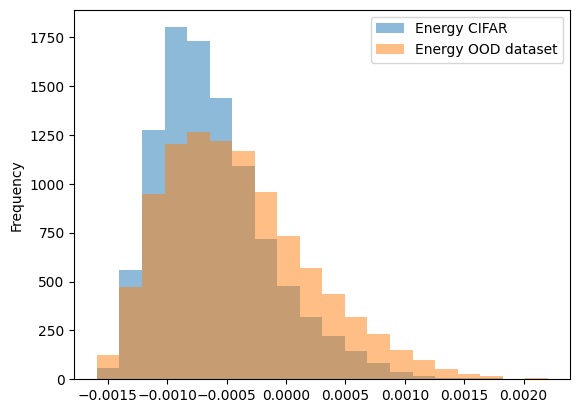

In [ ]:
fig = HistogramPlotter([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu()],
                        ["Energy CIFAR", "Energy OOD dataset"],
                        bins=20).plot()

We can see that there seems to be a very slight difference in energies between CIFAR-10 and Imagenet *at model initialization*. Hopfield Boosting detects the difference in energies and amplifies them.

## Energy with trained model

Now, we load the weights of a trained model to look at the OOD detection performance after training

In [ ]:
_ = load_model_weights(model_path, resnet, projection_head, classifier, epoch=99, device=DEVICE)

In [ ]:
# test model and verify test accuracy
classification_model = nn.Sequential(resnet, classifier)

with torch.no_grad():
    predictions = []
    ys = []
    for x, y in test_loader:
        x = x.to(DEVICE)
        ys.append(y)
        logits = classification_model(x)
        predictions.append(torch.argmax(logits, dim=-1).cpu())

    prediction = torch.concat(predictions, dim=0)
    ys = torch.concat(ys, dim=0)
print(f'Accuracy: {(prediction == ys).float().mean()}')

Accuracy: 0.9362000226974487


In [ ]:
print(classification_report(ys, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.934     0.947     0.940      1000
           1      0.961     0.974     0.967      1000
           2      0.928     0.914     0.921      1000
           3      0.860     0.873     0.867      1000
           4      0.933     0.950     0.942      1000
           5      0.881     0.892     0.886      1000
           6      0.963     0.955     0.959      1000
           7      0.978     0.947     0.962      1000
           8      0.961     0.961     0.961      1000
           9      0.967     0.949     0.958      1000

    accuracy                          0.936     10000
   macro avg      0.937     0.936     0.936     10000
weighted avg      0.937     0.936     0.936     10000



In [ ]:
# infer_loader iterates over the loader and creates the embeddings
cifar_embeddings = infer_loader(train_loader, embedding_model, device=DEVICE).__enter__()
ood_embeddings = infer_loader(ood_loader, embedding_model, device=DEVICE, max_samples=len(cifar_train)).__enter__()

In [ ]:
# OneSidedEnergy estimates the difference of energies of patterns in the CIFAR embeddings and the Imagenet embeddings
cifar_ood_classification_energy = OneSidedEnergy(a=cifar_embeddings, b=ood_embeddings, beta_a=cifar_beta, beta_b=ood_beta)

In [ ]:
cifar_energy_model = nn.Sequential(resnet, projection_head, cifar_ood_classification_energy)

cifar_test_cifar_train_energy = infer_loader(test_loader, cifar_energy_model, device=DEVICE).__enter__().cpu()
ood_cifar_train_energy = infer_loader(ood_loader, cifar_energy_model, device=DEVICE, max_samples=len(cifar_test)).__enter__().cpu()

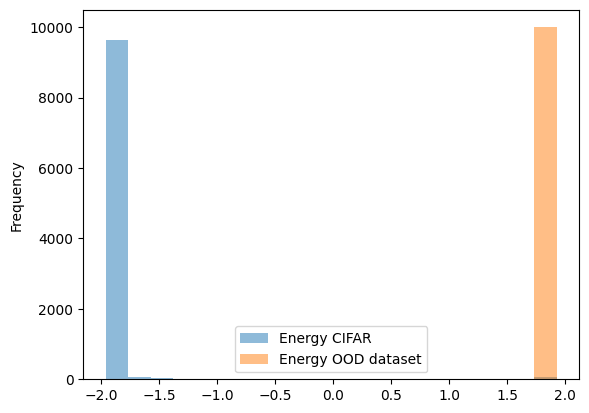

In [ ]:
fig = HistogramPlotter([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu()],
                        ["Energy CIFAR", "Energy OOD dataset"],
                        bins=20).plot()

## Evaluation with SVHN data set

In [ ]:
svhn_cifar_train_energy = infer_loader(svhn_loader, cifar_energy_model, device=DEVICE).__enter__().cpu()

AUROC: 0.9970347850000001
Wasserstein distance: 3.7123886929154395


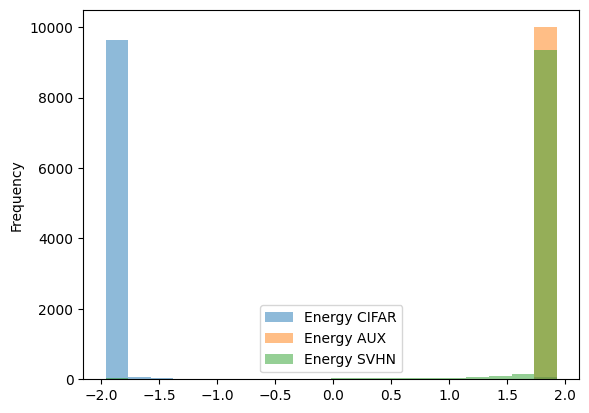

In [ ]:
fig = HistogramPlotter([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), svhn_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy AUX", "Energy SVHN"],
                      bins=20).plot()

# compute AUROC and Wasserstein distance between the two classes
labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(svhn_cifar_train_energy))], axis=0)
score = np.concatenate([cifar_test_cifar_train_energy, svhn_cifar_train_energy], axis=0)
print(f'AUROC: {roc_auc_score(labels, score)}')
print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, svhn_cifar_train_energy)}')

## Evaluation with Places data set

In [ ]:
places_cifar_train_energy = infer_loader(places_loader, cifar_energy_model, device=DEVICE).__enter__().cpu()

AUROC: 0.9852932249999999
Wasserstein distance: 3.1827909463763233


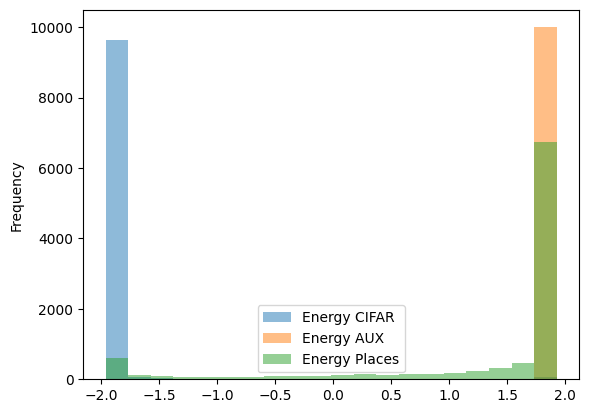

In [ ]:
fig = HistogramPlotter([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), places_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy AUX", "Energy Places"],
                      bins=20).plot()

# compute AUROC and Wasserstein distance between the two classes
labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(places_cifar_train_energy))], axis=0)
score = np.concatenate([cifar_test_cifar_train_energy, places_cifar_train_energy], axis=0)
print(f'AUROC: {roc_auc_score(labels, score)}')
print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, places_cifar_train_energy)}')

### Zoom to in-distribution class

(0.0, 200.0)

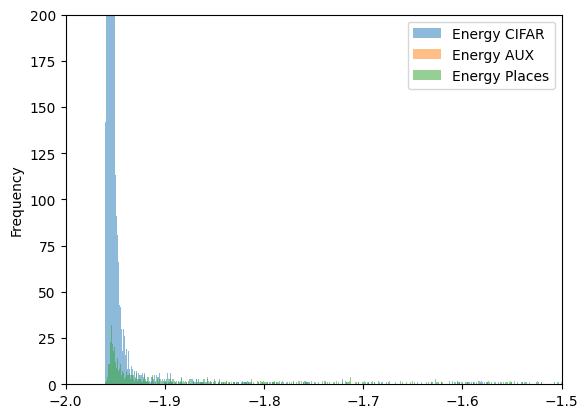

In [ ]:
# zoom in to in-distribution class.
fig = HistogramPlotter([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), places_cifar_train_energy.cpu()],
                      ["Energy CIFAR", "Energy AUX", "Energy Places"],
                      bins=5000).plot()

plt.xlim(-2., -1.5)
plt.ylim(0, 200)

### Look at wrongly predicted samples

In [ ]:
# This only works when the "shuffle" parameter in the torch DataLoader is set to False!

badly_predicted_energies, badly_predicted_samples = torch.sort(places_cifar_train_energy, descending=False)

<Figure size 2000x2000 with 0 Axes>

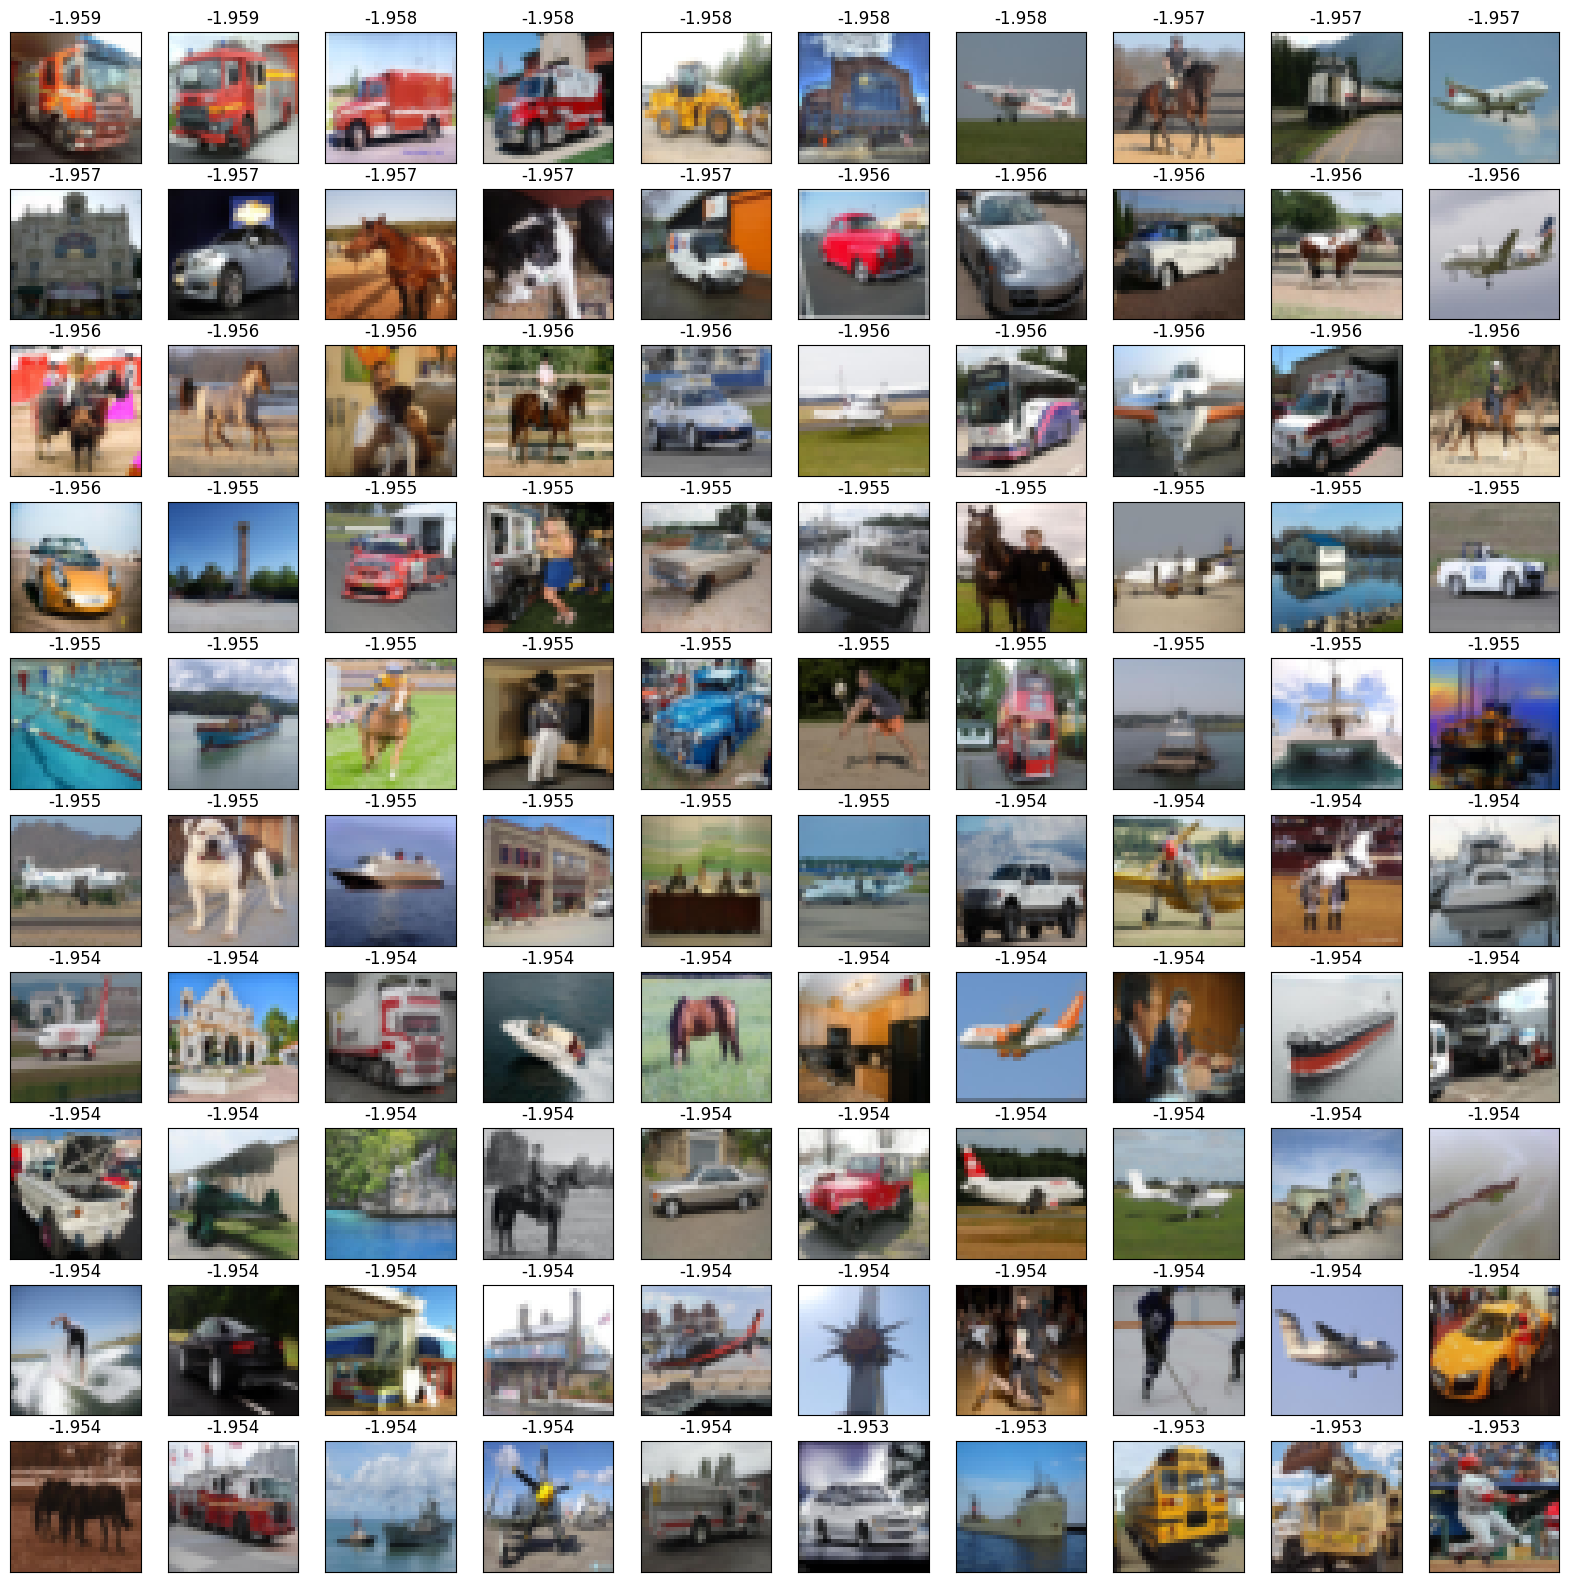

In [ ]:
nrows = 10
ncols = 10

_ = plt.figure(figsize=(20, 20))
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

for row in range(nrows):
    for col in range(ncols):
        image, _ = places[badly_predicted_samples[row * nrows + col]]
        image = transforms.ToPILImage()(image)
        axes[row][col].imshow(image)
        energy = float(badly_predicted_energies[row * nrows + col])
        axes[row][col].set_title("{:.3f}".format(energy))
        axes[row][col].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

## Evaluation with icartoonface data set
https://github.com/luxiangju-PersonAI/iCartoonFace

In [ ]:
random_state = 23
np.random.seed(random_state)

In [ ]:
def eval_energy_model(data_path,
                        transform=transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()]),
                        subset_size=10000,
                        replace=False,
                        energy_model=None,
                        device=DEVICE,
                        ):
    data_set =  ImageFolder(root=data_path, transform=transform)
    data_set = torch.utils.data.Subset(data_set, indices=np.random.choice(a=len(data_set), size=subset_size, replace=replace))

    data_loader = torch.utils.data.DataLoader(data_set, batch_size=1024, shuffle=False)

    energy = infer_loader(data_loader, energy_model, device=device).__enter__().cpu()

    return data_set, data_loader, energy


def plot_eval_hist(energy, label):
    fig = HistogramPlotter([cifar_test_cifar_train_energy.cpu(), ood_cifar_train_energy.cpu(), energy.cpu()],
                            ["Energy CIFAR", "Energy AUX", label],
                            bins=20).plot()

    # compute AUROC and Wasserstein distance between the two classes
    labels = np.concatenate([np.zeros(len(cifar_test_cifar_train_energy)), np.ones(len(energy))], axis=0)
    score = np.concatenate([cifar_test_cifar_train_energy, energy], axis=0)
    fpr95_metric = FPR95OODMetric()
    print(f'AUROC: {roc_auc_score(labels, score)}')
    print(f'FPR95: {fpr95_metric(-cifar_test_cifar_train_energy, -energy)}')
    print(f'Wasserstein distance: {wasserstein_distance(cifar_test_cifar_train_energy, energy)}')    

AUROC: 0.99564745
FPR95: 0.0066
Wasserstein distance: 3.602288434493542


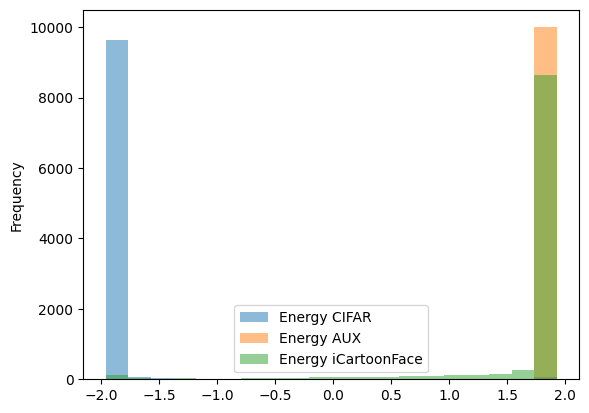

In [ ]:
icartoonface, icartoonface_loader, icartoonface_cifar_train_energy = eval_energy_model(
    data_path=ICARTOONFACE_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(icartoonface_cifar_train_energy, "Energy iCartoonFace")    

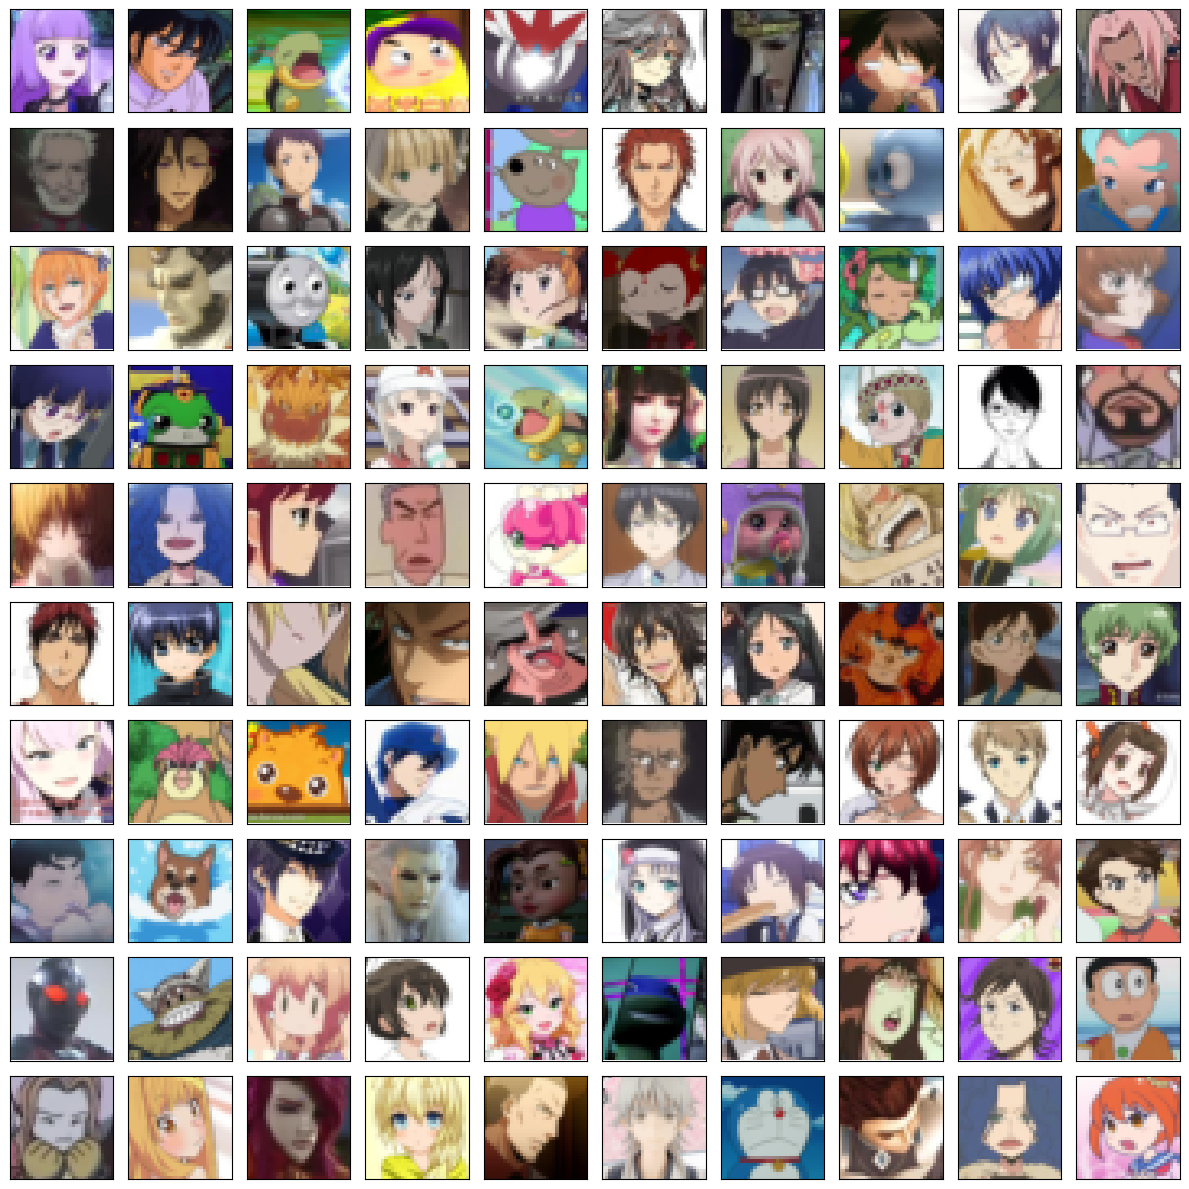

In [ ]:
fig = DatasetRandSamplePlotter(dataset=icartoonface,
                                n_samples=100,
                                figsize=(12,12)).plot()

## Evaluation with RPC data set
https://rpc-dataset.github.io/

AUROC: 0.9864042900000001
FPR95: 0.044
Wasserstein distance: 2.9529933694839476


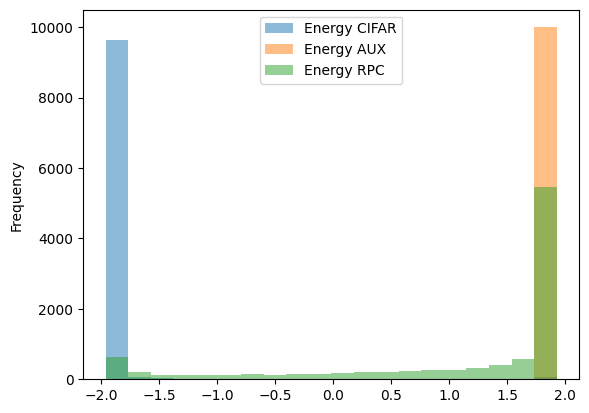

In [ ]:
rpc, rpc_loader, rpc_cifar_train_energy = eval_energy_model(
    data_path=RPC_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(rpc_cifar_train_energy, "Energy RPC")    

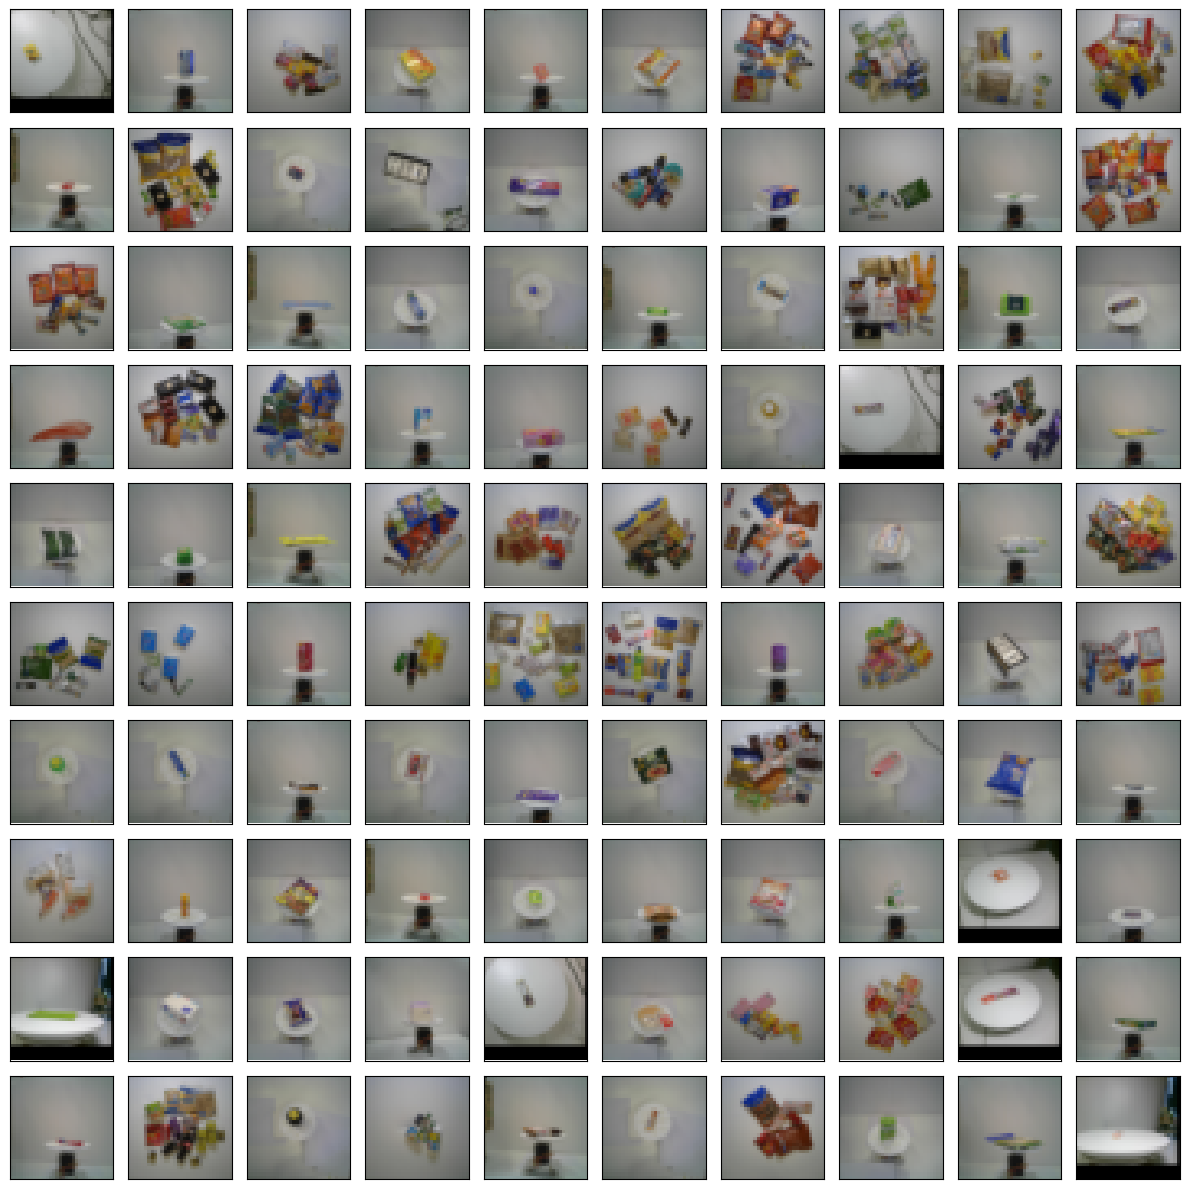

In [ ]:
fig = DatasetRandSamplePlotter(dataset=rpc,
                                n_samples=100,
                                figsize=(12,12)).plot()

## Evaluation with 3D Shapes data set
https://github.com/google-deepmind/3d-shapes

AUROC: 0.9979505250000001
FPR95: 0.0001
Wasserstein distance: 3.7650923384785653


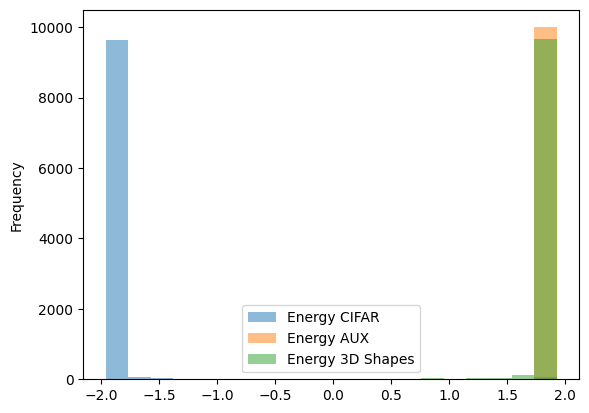

In [ ]:
shapes3d, shapes3d_loader, shapes3d_cifar_train_energy = eval_energy_model(
    data_path=SHAPES3D_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(shapes3d_cifar_train_energy, "Energy 3D Shapes")    

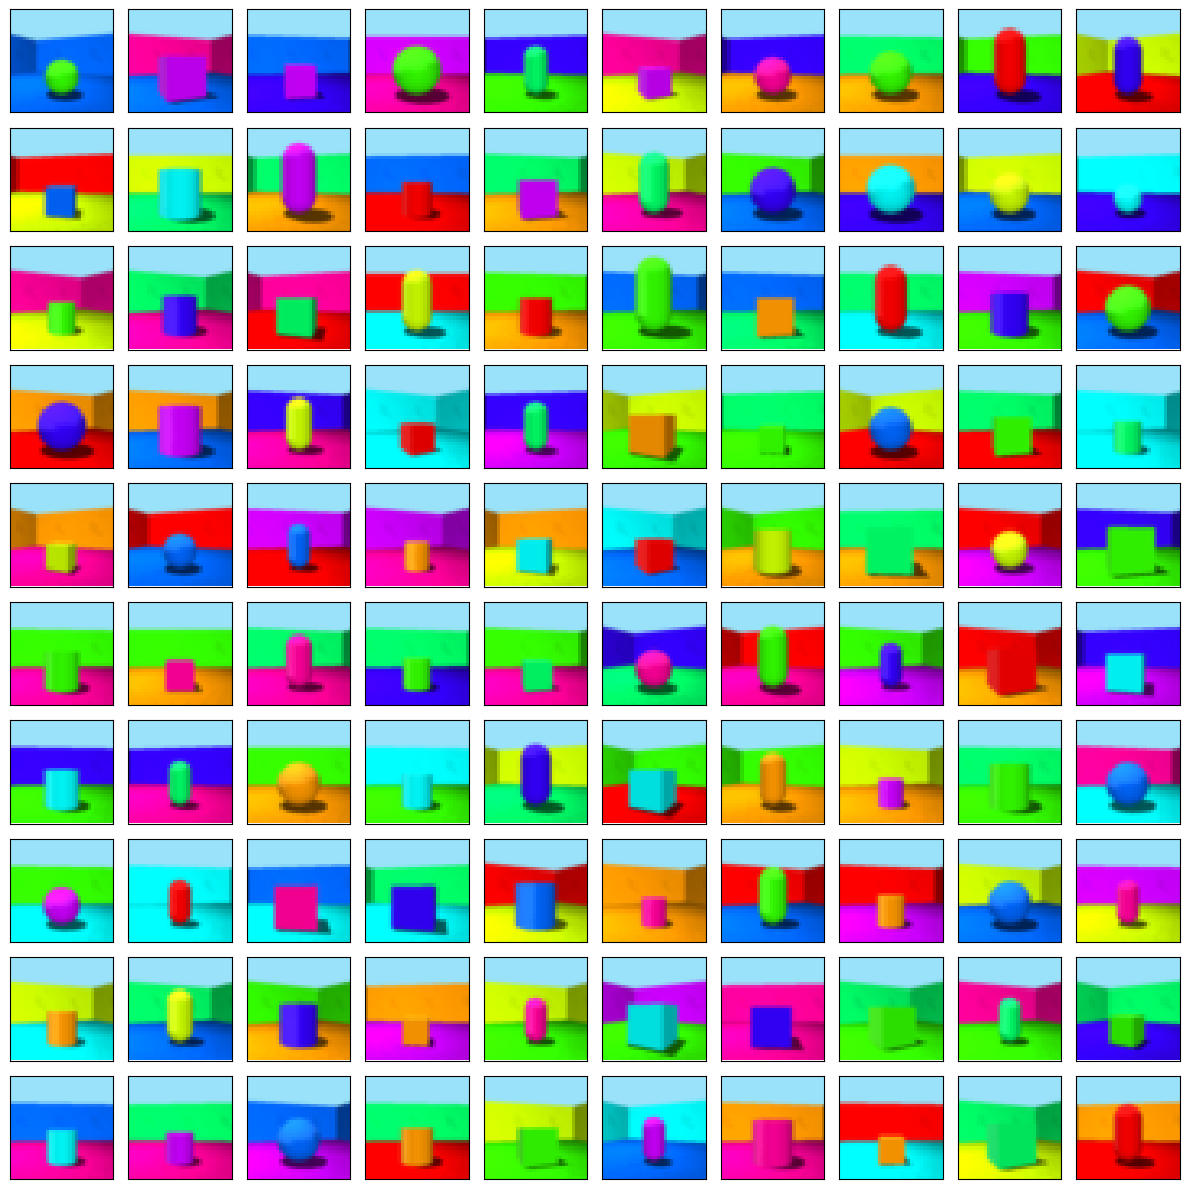

In [ ]:
fig = DatasetRandSamplePlotter(dataset=shapes3d,
                                n_samples=100,
                                figsize=(12,12)).plot()

## Evaluation with Four Shapes data set
https://www.kaggle.com/datasets/smeschke/four-shapes

AUROC: 0.906588395
FPR95: 0.4056
Wasserstein distance: 1.6079859888911248


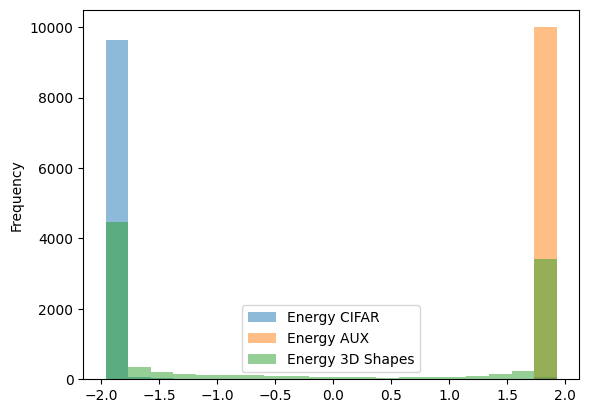

In [ ]:
four_shapes, four_shapes_loader, four_shapes_cifar_train_energy = eval_energy_model(
    data_path=FOUR_SHAPES_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(four_shapes_cifar_train_energy, "Energy 3D Shapes")    

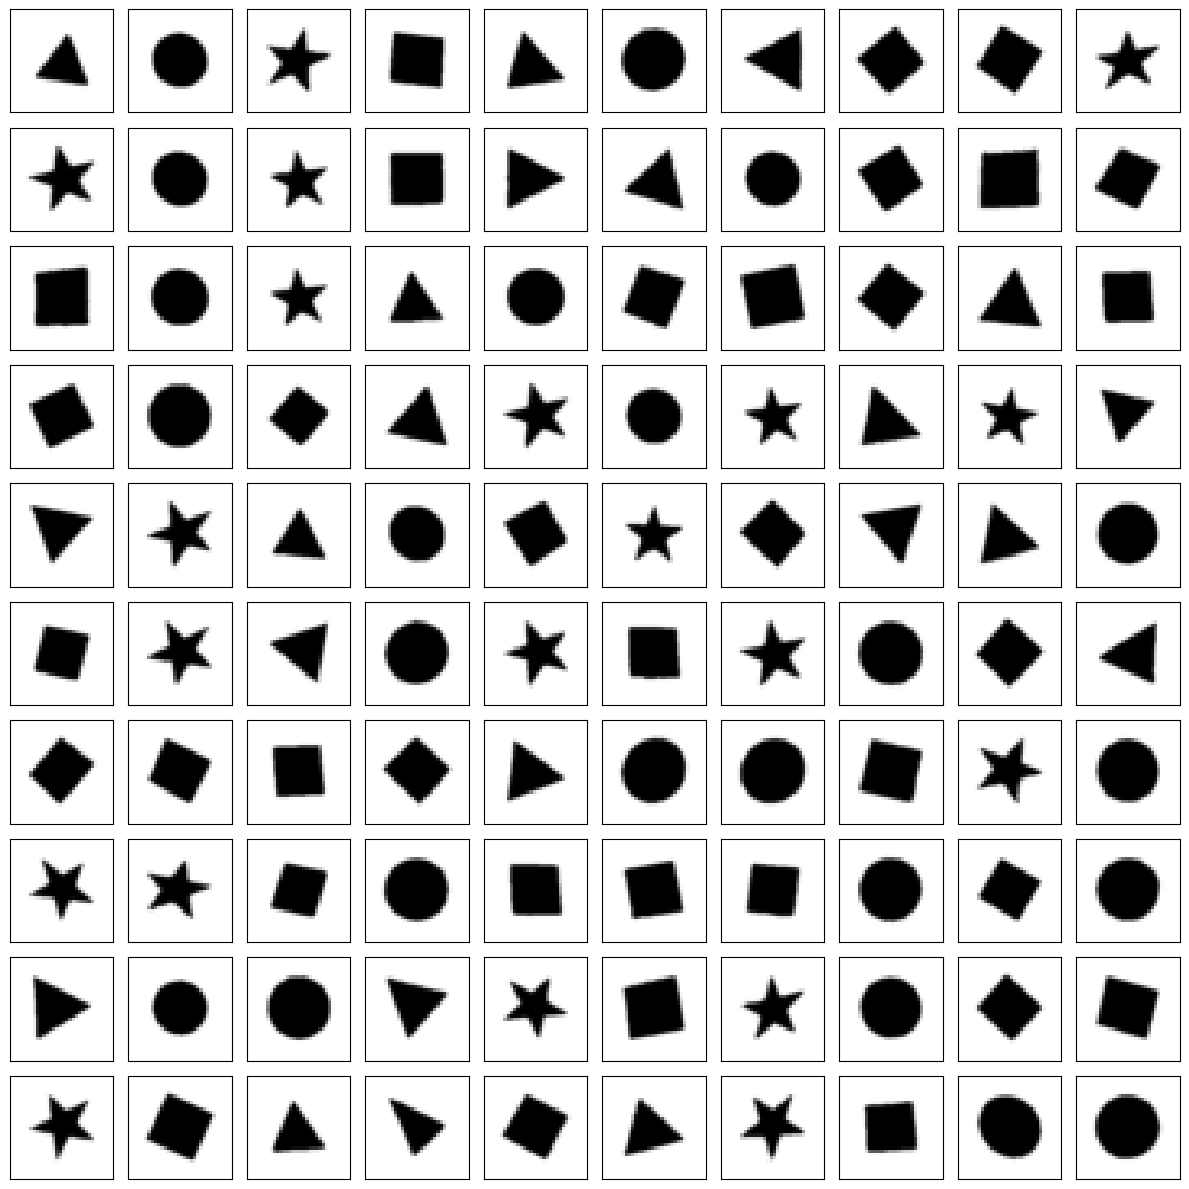

In [ ]:
fig = DatasetRandSamplePlotter(dataset=four_shapes,
                                n_samples=100,
                                figsize=(12,12)).plot()

## Evaluation with AFHQ_V2 data set
https://github.com/clovaai/stargan-v2/blob/master/README.md#animal-faces-hq-dataset-afhq

AUROC: 0.9250692150000001
FPR95: 0.2817
Wasserstein distance: 1.566837554848194


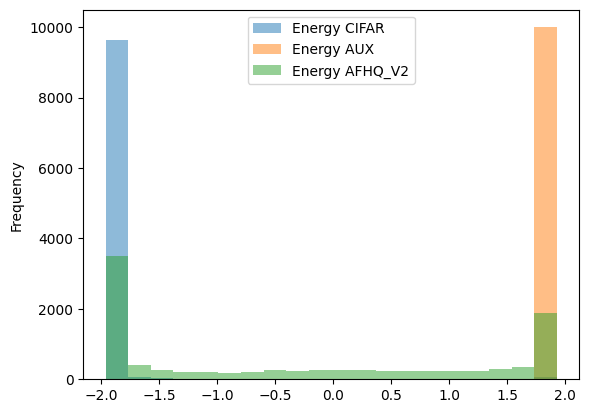

In [ ]:
afhq_v2, afhq_v2_loader, afhq_v2_cifar_train_energy = eval_energy_model(
    data_path=AFHQV2_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(afhq_v2_cifar_train_energy, "Energy AFHQ_V2")    

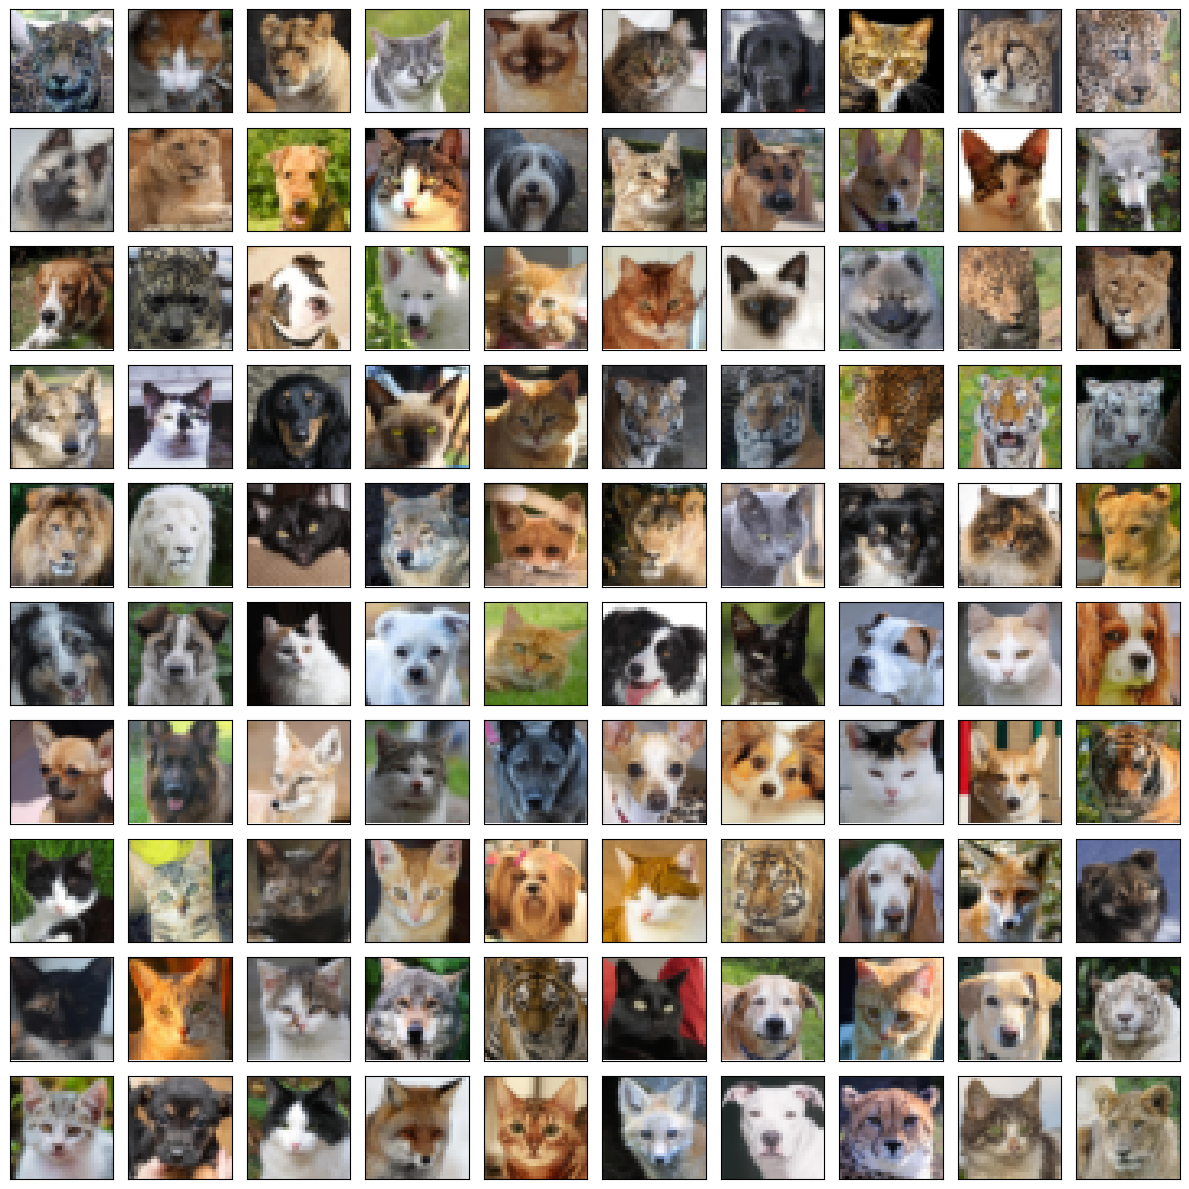

In [ ]:
fig = DatasetRandSamplePlotter(dataset=afhq_v2,
                                n_samples=100,
                                figsize=(12,12)).plot()

## Evaluation with tagged-anime-illustrations (moeimouto-faces) data set
https://www.kaggle.com/datasets/mylesoneill/tagged-anime-illustrations

AUROC: 0.99694896
FPR95: 0.0015
Wasserstein distance: 3.6838715472936627


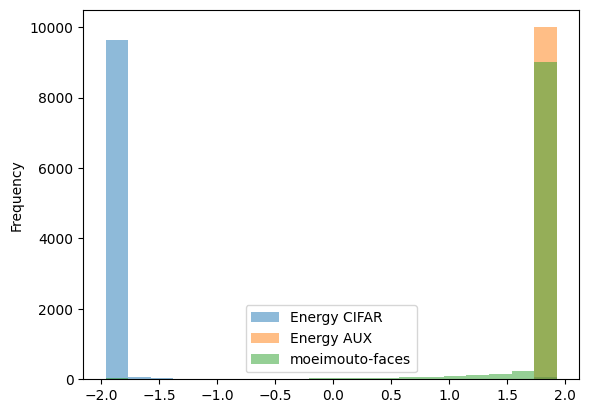

In [ ]:
moeimouto_faces, moeimouto_faces_loader, moeimouto_faces_cifar_train_energy = eval_energy_model(
    data_path=MOEIMOUTO_FACES_ROOT,
    energy_model=cifar_energy_model,
    )

plot_eval_hist(moeimouto_faces_cifar_train_energy, "moeimouto-faces")    

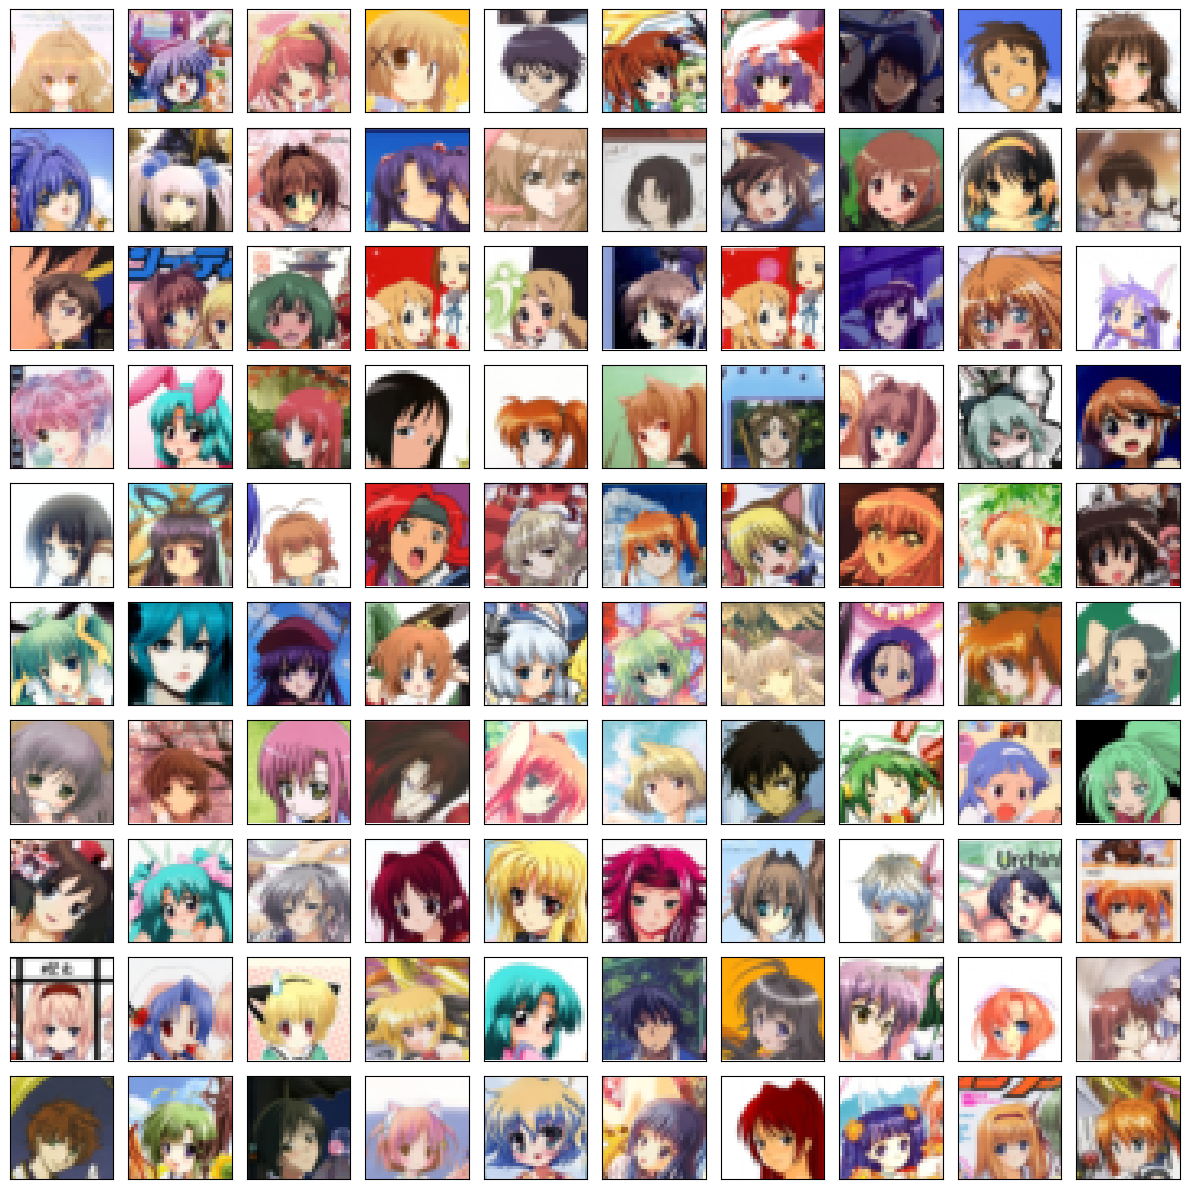

In [ ]:
fig = DatasetRandSamplePlotter(dataset=moeimouto_faces,
                                n_samples=100,
                                figsize=(12,12)).plot()

## Evaluation with natural adversarial example dataset ImageNet-O for out-of-distribution detectors
https://github.com/hendrycks/natural-adv-examples?tab=readme-ov-file

AUROC: 0.9917329300000001
FPR95: 0.0217
Wasserstein distance: 3.4327826951980582


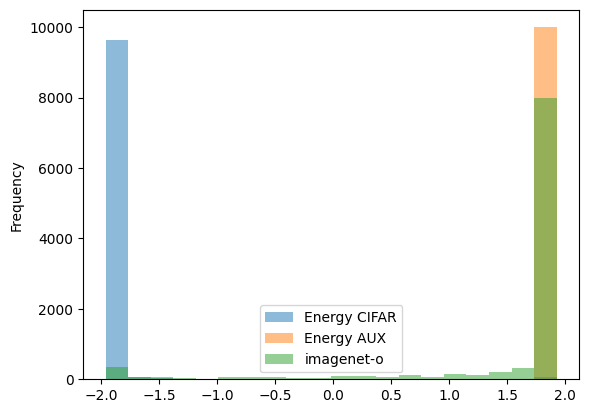

In [ ]:
imageneto, imageneto_loader, imageneto_cifar_train_energy = eval_energy_model(
    data_path=IMAGENETO_ROOT,
    energy_model=cifar_energy_model,
    replace=True,
    )

plot_eval_hist(imageneto_cifar_train_energy, "imagenet-o")

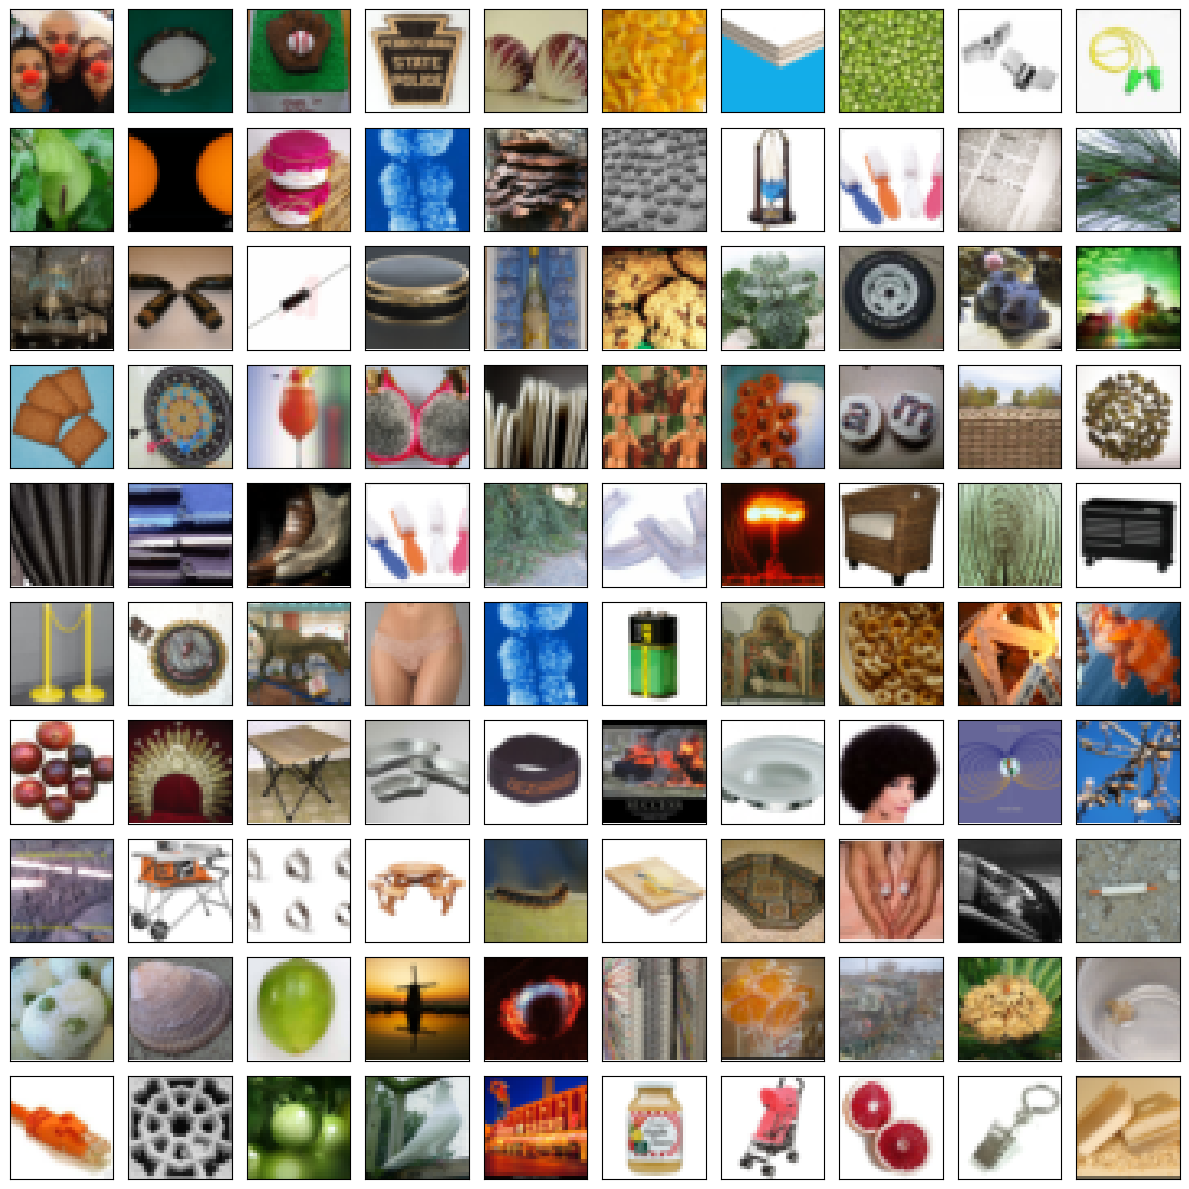

In [ ]:
fig = DatasetRandSamplePlotter(dataset=imageneto,
                                n_samples=100,
                                figsize=(12,12)).plot()